In [21]:
import pandas as pd
import networkx as nx
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import scipy.stats as sp
import collections
import networkx as nx
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.function as fn
from dgl.nn import GraphConv
import networkx as nx
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score


In [4]:
# Load edges (Graph connections)
edges = pd.read_csv("musae_facebook_edges.csv")

# Load features (Node features)
with open("musae_facebook_features.json") as f:
    features = json.load(f)

# Load target (Node labels)
targets = pd.read_csv("musae_facebook_target.csv")

In [5]:
# first few rows
print("Edges:")
print(edges.head())

print("\nTargets:")
print(targets.head())

Edges:
   id_1   id_2
0     0  18427
1     1  21708
2     1  22208
3     1  22171
4     1   6829

Targets:
   id       facebook_id                                     page_name  \
0   0   145647315578475                      The Voice of China 中国好声音   
1   1      191483281412                 U.S. Consulate General Mumbai   
2   2   144761358898518                                          ESET   
3   3   568700043198473  Consulate General of Switzerland in Montreal   
4   4  1408935539376139             Mark Bailey MP - Labor for Miller   

    page_type  
0      tvshow  
1  government  
2     company  
3  government  
4  politician  


EDGES
This represents the connections between Facebook pages. Each row (id_1, id_2) is an edge in the network.
Example: The first row means that Node 1 is connected to Node 18427.

TARGETS
Each row represents a Facebook page (node).
facebook_id: A unique identifier for each page.
page_name: The name of the page.
page_type: The category it belongs to, like:
tvshow
government
company
politician

Degree Distribution Summary:
count    22470.000000
mean        15.220472
std         26.414431
min          1.000000
25%          3.000000
50%          7.000000
75%         17.000000
max        709.000000
dtype: float64


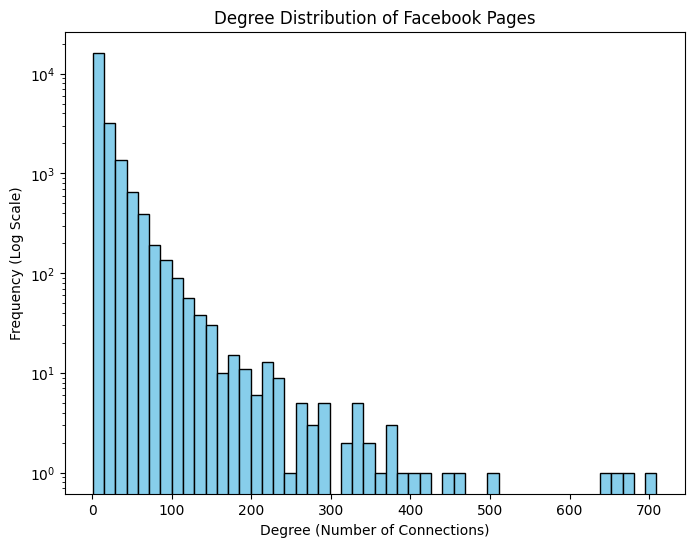

In [6]:
# Build Graph
G = nx.Graph()
G.add_edges_from(edges.values)

# Compute Degree for each node
degree_dict = dict(G.degree())
degree_series = pd.Series(degree_dict)

# Basic Stats
print("Degree Distribution Summary:")
print(degree_series.describe())

# Plot Degree Histogram
plt.figure(figsize=(8, 6))
plt.hist(degree_series, bins=50, color='skyblue', edgecolor='black', log=True)
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Frequency (Log Scale)")
plt.title("Degree Distribution of Facebook Pages")
plt.show()


the graph is highly skewed - most nodes have a very low degree,
most nodes have <10 connections

In [7]:
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")
print(f"Graph Density: {nx.density(G):.4f}")


Number of Nodes: 22470
Number of Edges: 171002
Graph Density: 0.0007


the denisty suggests that most nodes are not directly connected 

In [8]:

# Check Feature Size
num_nodes = len(features)
num_features = len(next(iter(features.values())))  # First node's features

print(f"Total Nodes in Features: {num_nodes}")
print(f"Each Node has {num_features} Features")

Total Nodes in Features: 22470
Each Node has 22 Features


In [9]:
# Print first node's features
first_node_id = list(features.keys())[0]
print("First node's features:", features[first_node_id])


First node's features: [2835, 4518, 2198, 2014, 3818, 3045, 4570, 4585, 4596, 4599, 4609, 4617, 4627, 4641, 4643, 4651, 4665, 4676, 4682, 4694, 4696, 4708]


In [10]:
# Define High-Degree and Low-Degree Thresholds
high_degree_threshold = degree_series.quantile(0.90)  # Top 10% most connected nodes
low_degree_threshold = degree_series.quantile(0.10)   # Bottom 10% least connected nodes

high_degree_nodes = degree_series[degree_series >= high_degree_threshold].index
low_degree_nodes = degree_series[degree_series <= low_degree_threshold].index

print(f"High-degree Nodes: {len(high_degree_nodes)}")
print(f"Low-degree Nodes: {len(low_degree_nodes)}")


High-degree Nodes: 2328
Low-degree Nodes: 2658


The top 10% (high-degree nodes) represent the most connected entities, while the bottom 10% (low-degree nodes) show the least connected.The two groups are close in size (2,328 vs. 2,658) - balanced comparison

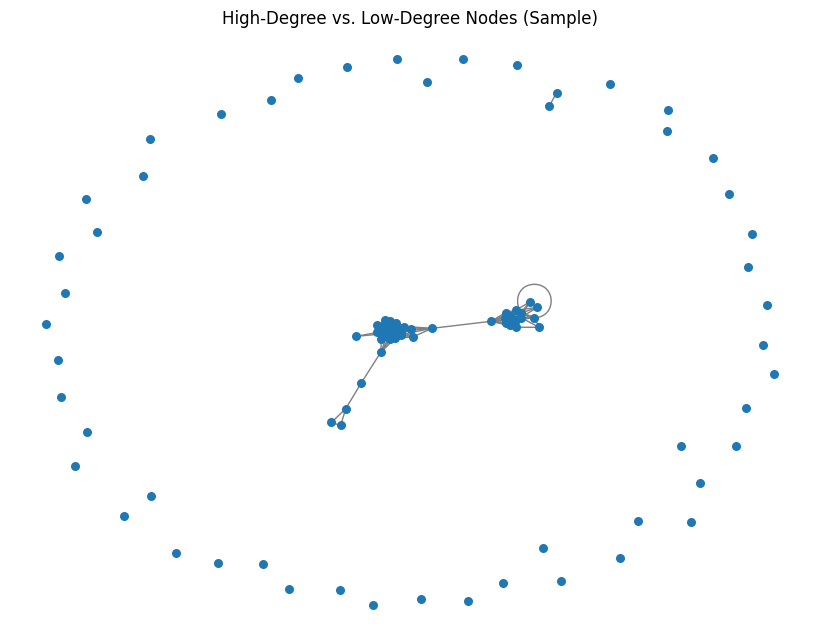

In [11]:
# Subgraph for Visualization
subgraph_nodes = list(high_degree_nodes)[:50] + list(low_degree_nodes)[:50]
subG = G.subgraph(subgraph_nodes)

plt.figure(figsize=(8, 6))
nx.draw(subG, node_size=30, edge_color="gray")
plt.title("High-Degree vs. Low-Degree Nodes (Sample)")
plt.show()


50 high-degree nodes (most connected)
50 low-degree nodes (least connected)

- Densely connected core in the center
- isolated nodes in the peripheral 

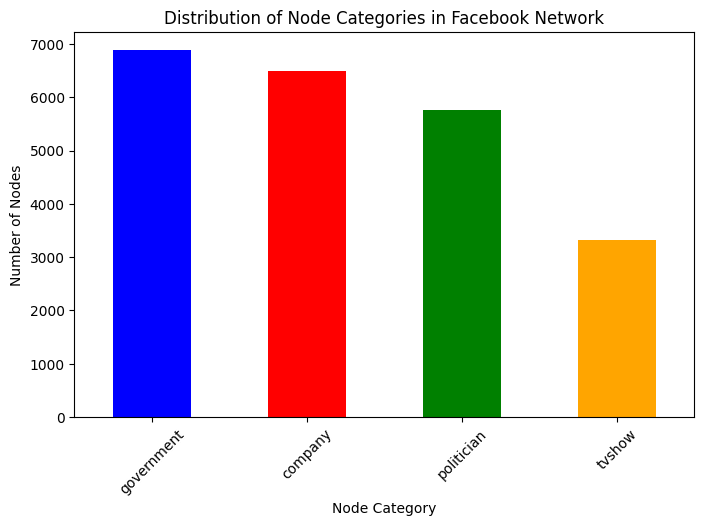

In [12]:
# Load node categories
targets = pd.read_csv("musae_facebook_target.csv")

# Count occurrences of each category
category_counts = targets['page_type'].value_counts()

# Plot Bar Chart
plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color=['blue', 'red', 'green', 'orange'])
plt.xlabel("Node Category")
plt.ylabel("Number of Nodes")
plt.title("Distribution of Node Categories in Facebook Network")
plt.xticks(rotation=45)
plt.show()


Government pages (~7,000 nodes) and Companies (~6,500 nodes) are the most common.
Politicians (~5,500 nodes) are slightly fewer.
TV Shows (~3,000 nodes) are the least represented.

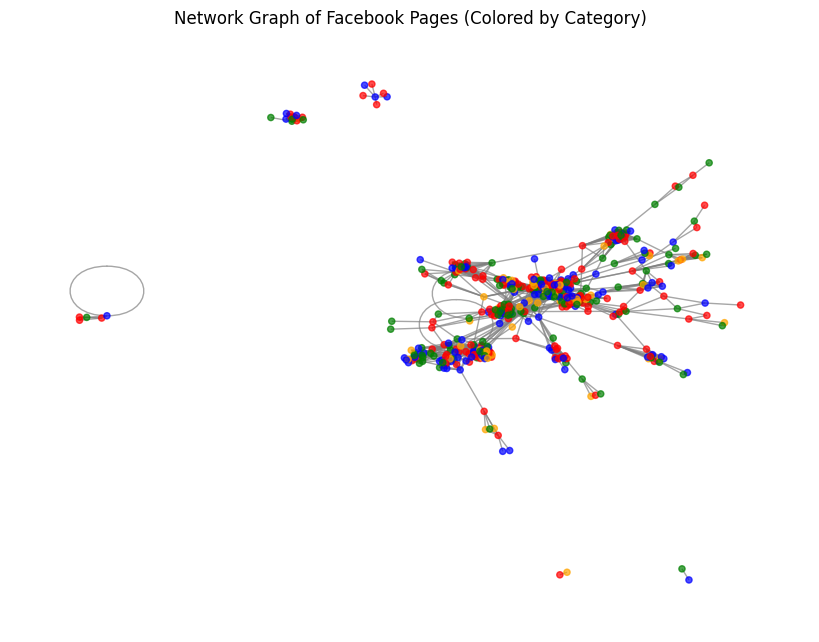

In [13]:
# Create a graph
edges = pd.read_csv("musae_facebook_edges.csv")
G = nx.Graph()
G.add_edges_from(edges.values)

# Define colors for categories
category_colors = {
    "politician": "blue",
    "government": "red",
    "company": "green",
    "tvshow": "orange"
}

# Assign node colors
node_colors = [category_colors.get(cat, "gray") for cat in targets['page_type']]

# Sample a subgraph for visualization (Too large to plot everything)
subG = G.subgraph(list(G.nodes)[:500])  # Adjust sample size if needed

plt.figure(figsize=(8, 6))
nx.draw(subG, node_size=20, node_color=node_colors[:500], edge_color="gray", alpha=0.7)
plt.title("Network Graph of Facebook Pages (Colored by Category)")
plt.show()



"politician" - blue
"government" - red
"company"- green
"tvshow" - orange

well-mixed categories

In [ ]:
# Load edges
edges = pd.read_csv("musae_facebook_edges.csv")
src, dst = edges["id_1"].values, edges["id_2"].values

# Load node features
with open("musae_facebook_features.json") as f:
    features_dict = json.load(f)

# Convert features to a tensor
num_nodes = len(features_dict)
feature_dim = max(max(feat_list) for feat_list in features_dict.values()) + 1  
features = torch.zeros((num_nodes, feature_dim))

for node, feat_list in features_dict.items():
    features[int(node), feat_list] = 1  # One-hot encoding features

# Create DGL graph and add self-loops 
graph = dgl.graph((src, dst), num_nodes=num_nodes)
graph = dgl.add_self_loop(graph)  # to avoid issues with isolated nodes


In [ ]:
# Create fake (negative) edges
def sample_negative_edges(graph, num_samples):
    neg_edges = []  # Start with an empty list

    while len(neg_edges) < num_samples:
        u = torch.randint(0, graph.num_nodes(), (num_samples,))
        v = torch.randint(0, graph.num_nodes(), (num_samples,))
        
        mask = ~graph.has_edges_between(u, v)  # Ensure sampled edges don't exist
        sampled_edges = torch.stack((u[mask], v[mask]), dim=1)

        neg_edges.extend(sampled_edges.tolist())  # Convert to list and append

        if len(neg_edges) > num_samples:
            neg_edges = neg_edges[:num_samples]  # Trim to required number

    return torch.tensor(neg_edges, dtype=torch.long)  # Convert back to tensor


In [ ]:
# GCN Encoder 
class GCNEncoder(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)  # ✅ Ensure no zero-in-degree error
        self.conv2 = GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

    def forward(self, graph, features):
        h = F.relu(self.conv1(graph, features))
        h = self.conv2(graph, h)
        return h


In [ ]:
# train and test edges 
# Convert edges into a tensor
positive_edges = torch.tensor(np.column_stack((src, dst)), dtype=torch.long)

# Sample an equal number of negative edges
negative_edges = sample_negative_edges(graph, len(positive_edges))

# Train-test split
pos_train, pos_test = train_test_split(positive_edges, test_size=0.2, random_state=42)
neg_train, neg_test = train_test_split(negative_edges, test_size=0.2, random_state=42)

# Create training and testing sets
train_edges = torch.cat([pos_train, neg_train], dim=0)
train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))]) # 1 - real; 0 - fake

test_edges = torch.cat([pos_test, neg_test], dim=0)
test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

print(f"Train edges: {train_edges.shape}, Test edges: {test_edges.shape}")


Train edges: torch.Size([273602, 2]), Test edges: torch.Size([68402, 2])


In [ ]:
# MLP decoder 
class MLPDecoder(nn.Module):
    def __init__(self, in_dim):
        super(MLPDecoder, self).__init__()
        self.fc1 = nn.Linear(in_dim * 2, in_dim)
        self.fc2 = nn.Linear(in_dim, 1)

    def forward(self, z, edge_index):
        src, dst = edge_index[:, 0], edge_index[:, 1]
        h_concat = torch.cat([z[src], z[dst]], dim=1)
        z = F.elu(self.fc1(h_concat))
        return torch.sigmoid(self.fc2(z)).squeeze()


In [ ]:
# train GAE 
class GAE(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super(GAE, self).__init__()
        self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
        self.decoder = MLPDecoder(out_dim)

    def forward(self, graph, features, edges):
        z = self.encoder(graph, features)
        return self.decoder(z, edges)

# Initialize model
hidden_dim = 128
out_dim = 64
model = GAE(feature_dim, hidden_dim, out_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(graph, features, train_edges)
    loss = loss_fn(output, train_labels)
    loss.backward()
    optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        test_output = model(graph, features, test_edges)
        test_loss = loss_fn(test_output, test_labels)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")


Epoch 1/20, Train Loss: 0.6932, Test Loss: 0.6434
Epoch 2/20, Train Loss: 0.6428, Test Loss: 0.5961
Epoch 3/20, Train Loss: 0.5933, Test Loss: 0.6306
Epoch 4/20, Train Loss: 0.6293, Test Loss: 0.5475
Epoch 5/20, Train Loss: 0.5453, Test Loss: 0.5589
Epoch 6/20, Train Loss: 0.5574, Test Loss: 0.5306
Epoch 7/20, Train Loss: 0.5298, Test Loss: 0.5408
Epoch 8/20, Train Loss: 0.5399, Test Loss: 0.5337
Epoch 9/20, Train Loss: 0.5325, Test Loss: 0.5118
Epoch 10/20, Train Loss: 0.5100, Test Loss: 0.5032
Epoch 11/20, Train Loss: 0.5006, Test Loss: 0.4996
Epoch 12/20, Train Loss: 0.4962, Test Loss: 0.4876
Epoch 13/20, Train Loss: 0.4838, Test Loss: 0.4829
Epoch 14/20, Train Loss: 0.4791, Test Loss: 0.4824
Epoch 15/20, Train Loss: 0.4784, Test Loss: 0.4693
Epoch 16/20, Train Loss: 0.4650, Test Loss: 0.4633
Epoch 17/20, Train Loss: 0.4585, Test Loss: 0.4566
Epoch 18/20, Train Loss: 0.4520, Test Loss: 0.4483
Epoch 19/20, Train Loss: 0.4440, Test Loss: 0.4450
Epoch 20/20, Train Loss: 0.4409, Test Lo

Both losses are decreasing steadily, the test loss is not increasing, which suggests there is no overfitting,

In [ ]:
# evaluation 
model.eval()
with torch.no_grad():
    test_preds = model(graph, features, test_edges).numpy()
    auc_score = roc_auc_score(test_labels.numpy(), test_preds)

print(f"AUC-ROC Score for Link Prediction: {auc_score:.4f}")

AUC-ROC Score for Link Prediction: 0.8835


 Steps Overview:
1️ Load the dataset (edges & features).
2️ Build the graph (DGL format).
3️ Create negative (fake) edges (needed for training).
4️ Split data into train & test sets (80% train, 20% test).
5️ Define the GCN Encoder (learns useful node representations).
6️ Define the MLP Decoder (predicts if two nodes should be connected).
7️ Train the model (minimizing prediction errors).
8️ Evaluate the model (measuring performance using AUC-ROC score).